# Starbucks Capstone Challenge

This project is one possibility analyzes the Starbucks Capstone 
This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

### What to do?

The ultimate goal of a data scientist is to generate business value. When sending adds there are multiple factors.
There are costs:
- Creating offers costs money. So an offer with zero response is lost effort
    - None of the offers have zero response. We can compare their effectiveness against eachother
- Deploying offers can be expensive if the offer have to sent over channels that are not controlled by the company. In this case an example would be deployment via social media
    - however we could figure out when it´s best to deploy offers
- Giving out rewards costs money. How much exactly e.g. a BOGO offer really costs the company only can be guessed since giving rewards of x$ sale value does cost the company less than x$. So we would have to make assumptions there. 
    - we could try to identify how much an offer increases spending. Therefore however we would need two groups. 

There are benefits
- Successful offers increase customer spending and therefore company profit

- classify if offer gets accepted
- classify if negative effect - we need some kind of controll group. search for it
  - we could try to identify demographic groups with similar behaviour but left out offers

## What we will do
- explore the data and see what we actually CAN da
- create a ML model that can predict if the offer gets accepted or not
- depending on the data another we can use SVD. 
    - There we could split the time data in half and predict the user reactions based on their an others previous behaviour
    - use the already implemented model to deal with the cold start problem
    - Then we can compare the aproaches
- figure out a way to get information about when not to send offers
- the ultimative goal would be a model that figures out by how much an offer in or decreases spending

## expectation
- high income do not react as well on adds as lower income
- older demographics won´t react as well.
- there will be a lot of inactive users who do not react at all



# Data Set


## Introduction to the dataset provided by Udacity & Starbucks
The following is all collected information we do have about the dataset.
### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.


## Additional infos about the data
Additional infos from the corresponding video: 
- "This is simulated data for the sake of testing the algorithms. Not simulated data for the sake of mimiking real people."
- "Some people might respond negatively"
- "The goal is to discover what the best offer is in there [...] on an induvidual personalized level"

## The actual data

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [10]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Explore and clean data

In [11]:
portfolio.head(15)
# we do have 3 different offer types. 
# - BOGO means By One Get One Free which is also why reward and difficulty match
# - informational only seems to be advertisement since there is no reward
# - discount is selfexplanatory. There however the difficulty VS reward seems a lot higher than BOGO

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [12]:
# now the cleaning process ... 
# create index containing type so we do not have to deal with hashes
portfolio.sort_values(['offer_type', 'reward', 'difficulty'], inplace=True)
offer_short_name = []
offer_type_counts = {}
for offer_type in portfolio.offer_type:
    offer_type = offer_type[0:4]
    offer_count = 0
    if not offer_type in offer_type_counts:
        offer_type_counts[offer_type] = 0
    else:
        offer_type_counts[offer_type] +=1
    offer_short_name.append(offer_type + str(offer_type_counts[offer_type]))
offer_short_name
portfolio['offer_short_name'] = offer_short_name

In [13]:
# as a final step let´s get the dummy variables
portfolio = portfolio.join(pd.get_dummies(portfolio.offer_type, dtype=np.int16))
portfolio = portfolio.join(pd.get_dummies(portfolio.channels.explode(), dtype=np.int16).sum(level=0))
portfolio.drop(columns = ['channels', 'offer_type'], inplace = True)

C:\Users\patri\AppData\Local\Temp/ipykernel_26368/1870637937.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  portfolio = portfolio.join(pd.get_dummies(portfolio.channels.explode(), dtype=np.int16).sum(level=0))


In [14]:
portfolio.head(15)

,reward,difficulty,duration,id,offer_short_name,bogo,discount,informational,email,mobile,social,web
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo0,1,0,0,1,1,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo1,1,0,0,1,1,1,1
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo2,1,0,0,1,1,1,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo3,1,0,0,1,1,1,1
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,disc0,0,1,0,1,1,1,1
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,disc1,0,1,0,1,1,0,1
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,disc2,0,1,0,1,1,1,1
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,disc3,0,1,0,1,0,0,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,info0,0,0,1,1,1,0,1
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,info1,0,0,1,1,1,1,0


In [15]:
# let´s have a look at the user profiles
profile.head(15)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


In [16]:
# We can see that there missing gender age and income 
# 118 seems to be the default value for a missing age
profile.age.replace(118, np.NAN, inplace=True)
# let´s drop all data that has zero information about a customer. We do want to make predictions about
# populations. Having zero information about a customer should result in little benefit.
# Losing 12% of entries also is not substantial. In a later iteration one could make another decision and
# train on the "no data" case as a special case.
mask_no_data = profile.gender.isnull() & profile.age.isnull() & profile.income.isnull()
print("Amount of dropped data: " + str(profile[mask_no_data].shape[0]/profile.shape[0]*100) + "%")
profile.drop(profile[mask_no_data].index,inplace=True)
profile[profile.gender.isnull()].shape[0], \
    profile[profile.age.isnull()].shape[0], \
        profile[profile.income.isnull()].shape[0]
# There were only entries missing all entires. No entry with single entries so no further decisions.

Amount of dropped data: 12.794117647058822%


(0, 0, 0)

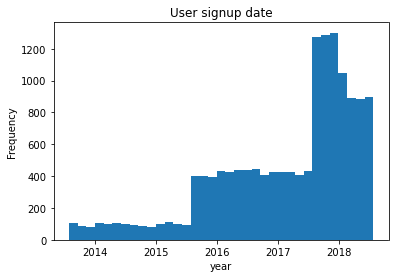

In [17]:
profile.became_member_on = pd.to_datetime(profile.became_member_on,format='%Y%m%d')
plt.hist(profile.became_member_on, bins = 35);
plt.title("User signup date");
plt.xlabel("year");
plt.ylabel("Frequency");
# it seems like there are four major groups of memebers. 
# - The ones that joind before mid of 2015
# - The big group that got joined starting mid of 2015. This most likely is related 
#   to the introduciton of Mobile Order & Pay expanded in June 2015. 
#   See https://stories.starbucks.com/stories/2015/year-in-review-2015-starbucks-innovations/
# - The even bigger group that started joining end of 2017
# - the other big group that joined in 2018 (here it is debatable though if they stil belog to the previous group)
# this indicates some major add campaign was going on during these events these years
# So it could be possible that at least the user profiles could be sampled from real data and not simulated

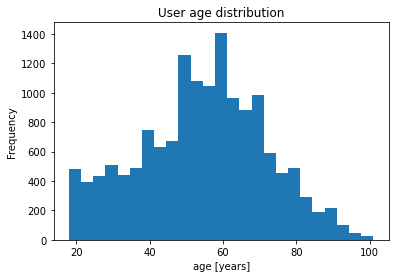

In [18]:
plt.hist(profile.age, bins = 25);

plt.title("User age distribution");
plt.xlabel("age [years]");
plt.ylabel("Frequency");
# the age distribution looks surprising. I would have expected a lot younger customer base esp.
# since this data is from a mobile app

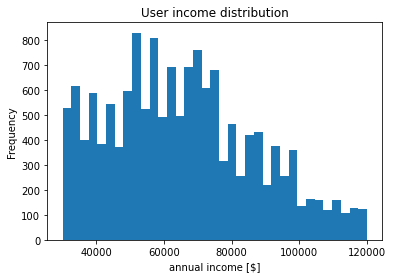

In [19]:
plt.hist(profile.income, bins = 35);

plt.title("User income distribution");
plt.xlabel("annual income [$]");
plt.ylabel("Frequency");
# income looks reasonable and is kind of comparable to the average US household 
# income distribution http://theglitteringeye.com/u-s-income-distributiona-chart-to-contemplate/ . 
# However the expected highvalue at the max position of 120k is missing. It also seems that in average
# the more wealthy households go to Starbucks

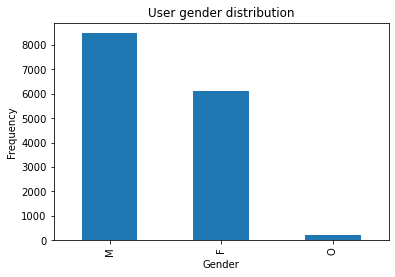

In [20]:
profile.gender.value_counts().plot(kind = 'bar');
plt.title("User gender distribution");
plt.xlabel("Gender");
plt.ylabel("Frequency");

# also looks reasonable. interesting though that there there are more male than female customers

C:\Users\patri\AppData\Local\Temp/ipykernel_26368/2673395200.py:4: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  profile_plt.became_member_on = profile_plt.became_member_on.astype(np.int64)


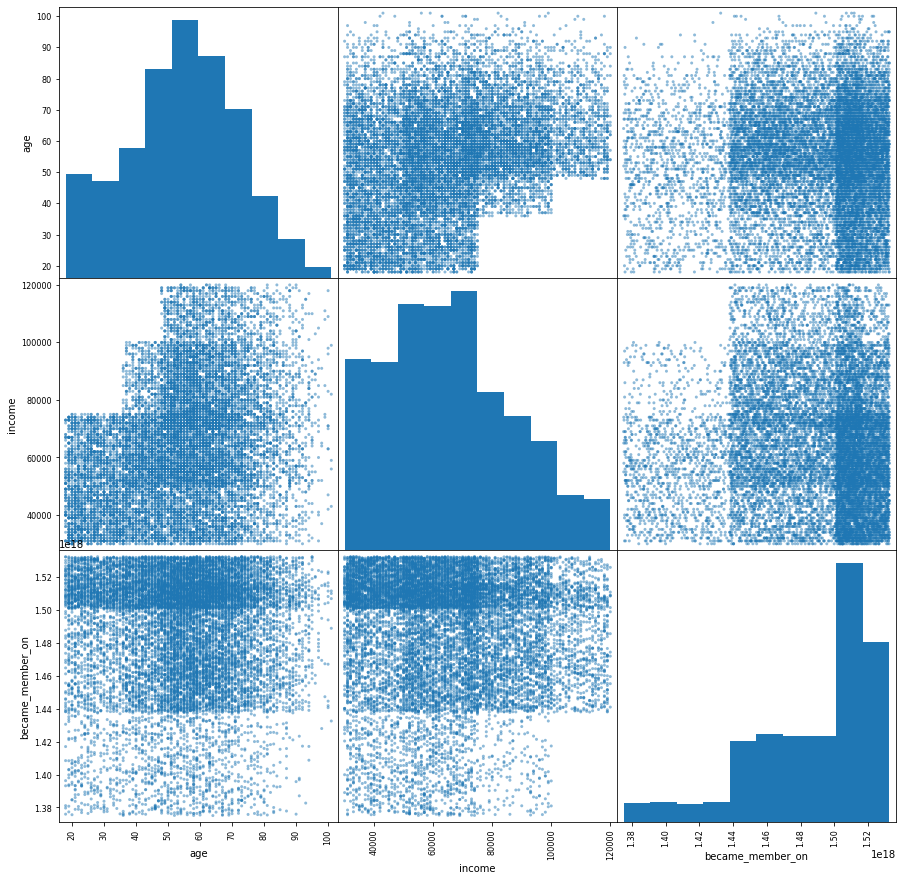

In [21]:
# so now we can look at things combined everything:
profile_plt = profile.copy()
# unfortunatly pd scatter does not work for datetime so we do have deal with ints
profile_plt.became_member_on = profile_plt.became_member_on.astype(np.int64)
pd.plotting.scatter_matrix(profile_plt[['age','income', 'became_member_on']], figsize=(15,15));


interesting things to see are that
- there seems like an artificial limit for income. There is no customer till the age of 35 that makes more than 80k$ and noone below 50 years who makes more than 100k$.
- before mid of 2015 the max income you could enter at the signup process seems to be 100k because noone that signed up before has a higher number
We have to keep in mind that this is simulated data. Since this is simulated data weird effects also might come from the simulation

In [22]:
transcript.head(15)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [23]:
# Let´s clean the event data
# so we have data of all costomers that are related to interactions. That´s good :)
profile.id.isin(transcript.person).mean()
transcript.person.isin(profile.id).mean() 
# now we get rid of the events that concern customers we have no profile data
mask_no_data = ~transcript.person.isin(profile.id)
print("Amount of dropped data: " + str(transcript[mask_no_data].shape[0]/transcript.shape[0]*100) + "%")
transcript.drop(transcript[mask_no_data].index,inplace=True)

Amount of dropped data: 11.017374907840566%


In [24]:
transcript = pd.concat([transcript.drop(['value'], axis=1), transcript.value.apply(pd.Series)], axis=1)
# we get rid of the dict and clean up the duplicated offer_id entry
transcript.offer_id.fillna(transcript['offer id'], inplace=True)
transcript.drop(columns=['offer id'],inplace=True)
# and create dummy variables for the event
transcript = transcript.join(pd.get_dummies(transcript.event, dtype=np.int16))
transcript.rename(columns={'offer completed': 'offer_completed', \
    'offer received' : 'offer_received', 'offer viewed' : 'offer_viewed'}, inplace=True)

In [25]:
# now we can combine everything: 
profile.rename(columns={'id': 'person'}, inplace=True)
transcript = transcript.merge(profile, how='left', on='person')
portfolio.rename(columns={'id': 'offer_id', 'reward' : 'offer_reward'}, inplace=True)
transcript = transcript.merge(portfolio, how='left', on='offer_id')
rewards = transcript.query("event == 'offer completed'")[['reward','offer_reward']]

np.sum(rewards.reward != rewards.offer_reward)
# reward and offer reward match so we can drop the event reward
transcript.drop(columns=['reward'],inplace=True)

In [26]:
transcript.head()

,person,event,time,amount,offer_id,offer_completed,offer_received,offer_viewed,transaction,gender,...,difficulty,duration,offer_short_name,bogo,discount,informational,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,F,...,5.0,7.0,bogo0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,0,1,0,0,M,...,10.0,7.0,disc1,0.0,1.0,0.0,1.0,1.0,0.0,1.0
2,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0,M,...,5.0,5.0,bogo1,1.0,0.0,0.0,1.0,1.0,1.0,1.0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,NaN,3f207df678b143eea3cee63160fa8bed,0,1,0,0,M,...,0.0,4.0,info0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0,F,...,20.0,10.0,disc3,0.0,1.0,0.0,1.0,0.0,0.0,1.0


14825

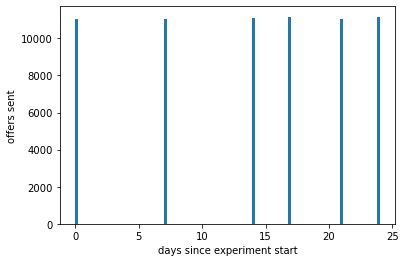

In [27]:
# Let´s have a look at the recorded event data and try to understand the experiment
transcript.time.max()/24
# we do have roughly 30 days of event data. 30 days after signup for each customer? 30 days of events of all customers? 
# the assumption is that this is 30 continuous days of events since that makes most sense in terms of an experiment
plt.hist(transcript.query("event == 'offer received'").time/24,bins=100);

plt.xlabel("days since experiment start");
plt.ylabel("offers sent");
transcript.person.nunique()
# Within these 30 days at six different times offers get sent. The amount of offers sent each time roughly equals 
# the amount of users.

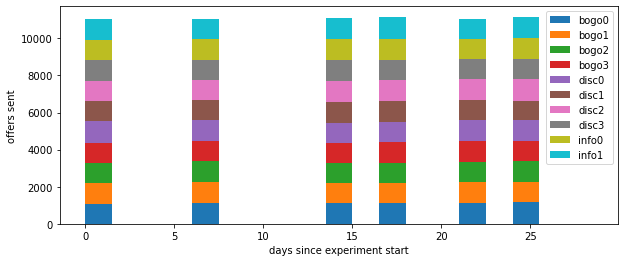

In [28]:
# let´s figure out if there is a systematic when which offer was sent
ids = portfolio.offer_id.dropna().unique()
offers_sent = transcript.query("event == 'offer received'")
bins = np.arange(0,30,1.5)
stacked_offers = []
offer_names = []
for id in ids:
    vals = offers_sent.query("offer_id == @id").time/24
    stacked_offers.append(vals)
    offer_names.append(offers_sent.query("offer_id == @id").offer_short_name.dropna().unique()[0])
plt.figure(figsize=(10, 4))
plt.hist(stacked_offers, bins=bins,histtype='bar', stacked=True);
# TODO: create legend
plt.legend(offer_names,loc='upper right');
plt.xlabel("days since experiment start");
plt.ylabel("offers sent");
# all different offer types are sent out each time in roughly equal amounts to the customers

In [29]:
offer_waves = (transcript.person.nunique() - transcript.query("event == 'offer received'").time.value_counts()\
    .sort_values())/transcript.person.nunique()*100
offer_waves2 = (transcript.person.nunique() - transcript.query("offer_received == 1").time.value_counts()\
    .sort_values())/transcript.person.nunique()*100
offer_waves
# about a quarter of users does get no offer each wave

0      25.645868
504    25.477234
168    25.389545
336    25.261383
408    24.964587
576    24.688027
Name: time, dtype: float64

C:\Users\patri\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,all offers,offers excluding informational
5,5173,2748.0
4,4362,4561.0
6,2663,675.0
3,2028,4164.0
2,532,2059.0
1,62,557.0
0,5,61.0


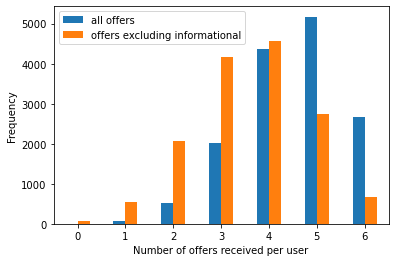

In [30]:
# we want to know if there is an easy control group that never get´s any offer
plot_df = pd.DataFrame()
plot_df['all offers'] = transcript.groupby(['person']).sum()['offer_received'].value_counts()
plot_df['offers excluding informational'] = \
    transcript.query("informational == 0").groupby(['person']).sum()['offer_received'].value_counts()
plot_df.fillna(0, inplace = True)
# add customers that we filtered out again
plot_df['offers excluding informational'].loc[0] += \
    transcript.person.drop_duplicates().isin(transcript.query("informational == 0").person).value_counts().loc[False]
plot_df.sort_index().plot.bar(rot=0)
plt.xlabel("Number of offers received per user")
plt.ylabel("Frequency")
plot_df.head(10)
# The number of customers receiving no offer matches the expectation given the 25% of users
# are sampled randomly
# Looks like there is at least no easy control group for the whole experiment
# an option would be to not count informational offers as real offers but also then there is no
# control group with a sufficient size.

,wave 1,wave 2,wave 3,wave 4,wave 5,wave 6
0,3802.0,952.0,251.0,65.0,18.0,5
1,11023.0,5662.0,2180.0,738.0,231.0,62
2,0.0,8211.0,6198.0,3201.0,1407.0,532
3,0.0,0.0,6196.0,6136.0,3918.0,2028
4,0.0,0.0,0.0,4685.0,5718.0,4362
5,0.0,0.0,0.0,0.0,3533.0,5173
6,0.0,0.0,0.0,0.0,0.0,2663


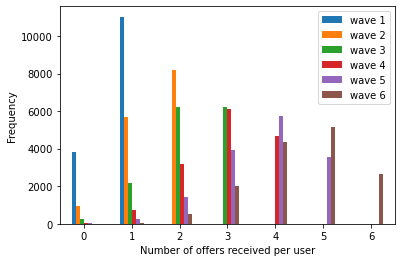

In [31]:
wave_times = np.sort(offer_waves.index)
received_offers = []
labels = []
plot_df = pd.DataFrame(index=range(7))
wave_id = 1
for time in wave_times:
    customer_per_time = transcript.query("time < (@time+1)").groupby(['person']).sum()
    wave_name = "wave " + str(wave_id)
    wave_id += 1
    plot_df[wave_name] = customer_per_time['offer_received'].value_counts()
    plot_df.fillna(0, inplace = True)
    try:
        plot_df[wave_name].loc[0] += \
            transcript.person.drop_duplicates().isin(customer_per_time.index).value_counts().loc[False]
    except:
        pass

plot_df.sort_index().plot.bar(rot=0)
plt.xlabel("Number of offers received per user")
plt.ylabel("Frequency")
plot_df.head(10)

In [32]:
# At least for the first wave we would have a big enough control group. one option would be to treat this first
# wave as an individual experiment and investigate this as an A/B test. Since there are 10 different offers tested at the same time
# each control group would around 400 data points.
# another option is the assumption in the data desciption:
# "for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the 
# offer for 7 days after receiving the advertisement."
# Since we are working with simulated data this is probably an asumption of the simulation as well. So we might not suffer from
# effects of previous offers treating the waves as individual experiments only with different historic data

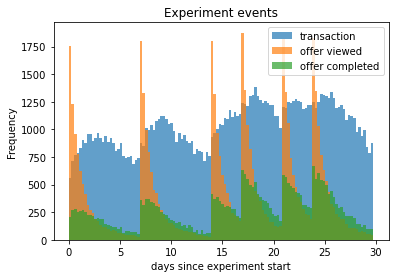

In [33]:
num_bins = 120
transparancy = 0.7
events = ['transaction', 'offer viewed', 'offer completed']
for event in events:
    (transcript.query("event == @event").time/24).plot.hist(bins=num_bins, alpha = transparancy, label = event);
plt.title("Experiment events");
plt.legend(loc='upper right');
plt.xlabel("days since experiment start");
# it looks like the offers have a positve impact on the number of transactions.

So we now do understand what happens:
 - all offers are sent in roughly equal amounts to customers in 6 waves
 - 25% of customers do not get an offer per wave
 - no user get´s the same offer twice
 - the assumption is that which offer is sent to which user is done by random sampling
this hypothesis could be confirmed investigating it´s statistical significance

In [34]:
# lets have a look how the individual waves impact the users. Wave one can be treated as an A/B test 

def get_events_by_wave(transcript):
    """
    Splits event data into the different offer waves

    Args:
        transcript (pd.Dataframe): df containing all event data

    Returns:
        list[pd.Dataframe]: list of data frames each containing one set of events
    """
    offer_wave_times = np.sort(transcript.query("event == 'offer received'").time.value_counts().index)
    data_during_waves = []
    transcript_copy = transcript.copy()
    transcript_copy.amount.fillna(0,inplace=True)
    for i_wave in range(6):
        start_time = offer_wave_times[i_wave] -1
        end_time = 10000
        if i_wave < 5:
            end_time = offer_wave_times[i_wave + 1] - 24
        data_during_waves.append(transcript.query("time > @start_time & time <@end_time"))
    return data_during_waves

def merge_events_to_user(transcript):
    """
    merges event data to the information we have about the user

    Args:
        transcript (pd.Dataframe): df containing all event data
    
    Returns:
        pd.Dataframe: df containing user attributes and event informations
    """

    wave_data = get_events_by_wave(transcript)
    user_event_data = pd.DataFrame()
    user_event_data['person'] = transcript.person.dropna().unique()
    for i_wave in range(6):
        wave = wave_data[i_wave]
        # let´s get the offers
        offer_type = wave.query("(event == 'offer received')")[['offer_short_name','person']]
        offer_type.rename(columns ={'offer_short_name' : 'w'+str(i_wave+1) +'_' + 'offer'},inplace = True)
        user_event_data = user_event_data.merge(offer_type, left_on='person', right_on='person',how='left').fillna('control')
        # let´s grab the summed data
        user_data = wave.groupby('person').sum()[['amount','transaction','offer_completed','offer_received','offer_viewed']]
        user_data.columns = 'w'+str(i_wave+1) +'_' + user_data.columns.values
        user_event_data = user_event_data.merge(user_data, left_on='person', right_on='person',how='left').fillna(0)
    return user_event_data
        
user_event_data = merge_events_to_user(transcript)

In [35]:
def plot_confidence_spending_change_by_offer(user_event_data, wave):
    """
    Plots effects of different offers on the mean user spending by comparing it to the control group that does
    not recieve any offer. For generating a confidence interval bootstrapping is used.

    Args:
        data_during_wave: dataframe containing user events during one offer wave
        all_user_ids: all ids. necessary because there might be persons without events in the event data
    """
    # null hypothesis H0: receiving offers does not increase the average spending
    # H1 is that it increases spending
    # we can use bootstrapping to get a confidence interval of this hypothesis. Lets do that for all types
    wave_prefix = 'w' + str(wave) + '_'
    field_name_transaction = wave_prefix + 'transaction'
    field_name_offer = wave_prefix + 'offer'
    offers = np.sort(user_event_data[wave_prefix+'offer'].unique())
    offers = np.delete(offers, np.argwhere(offers == 'control'))
    
    nrows=3
    ncols=4
    row = 0
    col = 0
    fig, axes = plt.subplots(nrows, ncols,figsize=(14,10))
    fig.tight_layout(h_pad=4, w_pad=4)
    fig.canvas.set_window_title('Influence of offer on spending')
    for offer in offers:
        diffs = []
        red_user_event_data = user_event_data[[field_name_offer,field_name_transaction]].copy()
        for _ in range(1000):
            bootsamp = red_user_event_data.sample(red_user_event_data.shape[0], replace = True)
            nooffer_mean = bootsamp.query(field_name_offer +" == 'control'")[field_name_transaction].mean()
            offer_mean = bootsamp.query(field_name_offer +" == @offer")[field_name_transaction].mean()
            diffs.append(offer_mean - nooffer_mean)
        
        plt.sca(axes[row,col])
        if col +1 >= ncols:
            col = 0
            row +=1
        else:
            col +=1
        
        plt.title(offer + " offer")
        diff_experiment = user_event_data.query(field_name_offer +" == @offer")[field_name_transaction].mean() - \
            user_event_data.query(field_name_offer +" == 'control'")[field_name_transaction].mean()
        plt.axvline(diff_experiment, color = 'black',label = "experiment");
        plt.hist(diffs,bins=40)
        ci_interval = 95
        # H1 is one tailed so we can cut off 5% for the 95% confidence interval
        plt.axvline(np.mean(diffs), color = 'grey',label = "mean");
        plt.axvline(np.percentile(diffs, 100 - ci_interval), color = 'red',label = str(ci_interval) + "% CI");
        plt.legend(loc='upper right');
        plt.xlabel("Mean increase in sales per user [$]")
        plt.ylabel("Frequency")
    axes[2,3].axis('off')
    axes[2,2].axis('off')

## How well are the different offers doing?

### Impact on revenue
Let´s have a look at increase in spending for the first offer wave:

C:\Users\patri\AppData\Local\Temp/ipykernel_26368/2434196050.py:25: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title('Influence of offer on spending')


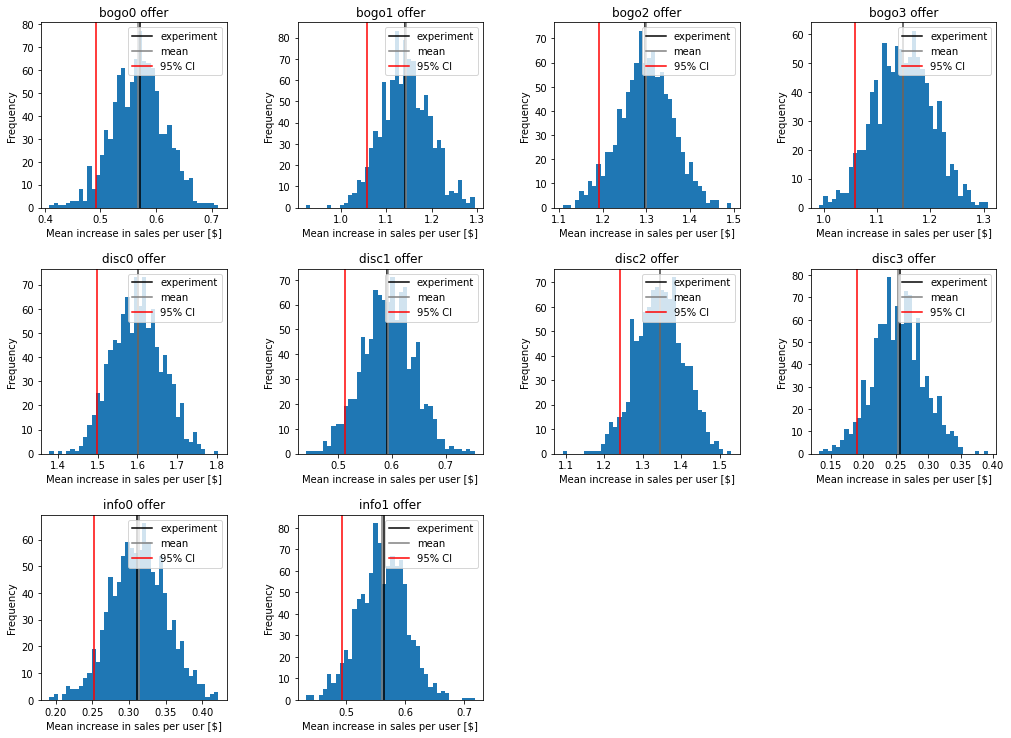

In [36]:
plot_confidence_spending_change_by_offer(user_event_data, 1)

C:\Users\patri\AppData\Local\Temp/ipykernel_26368/2434196050.py:25: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title('Influence of offer on spending')


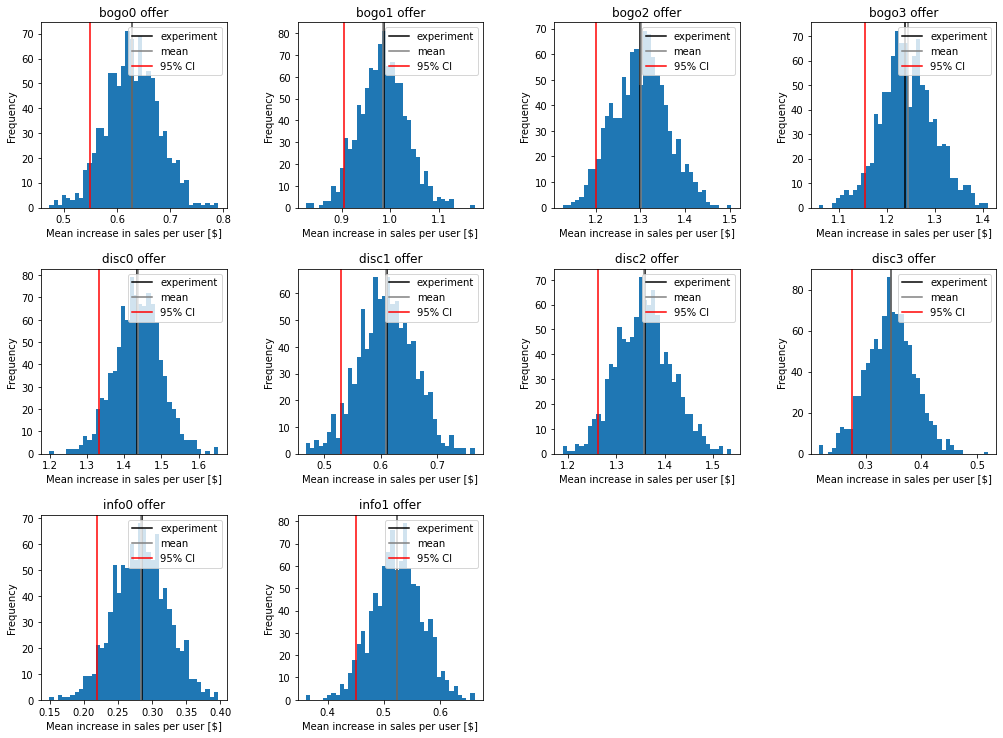

In [37]:
plot_confidence_spending_change_by_offer(user_event_data, 2)

C:\Users\patri\AppData\Local\Temp/ipykernel_26368/2434196050.py:25: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title('Influence of offer on spending')


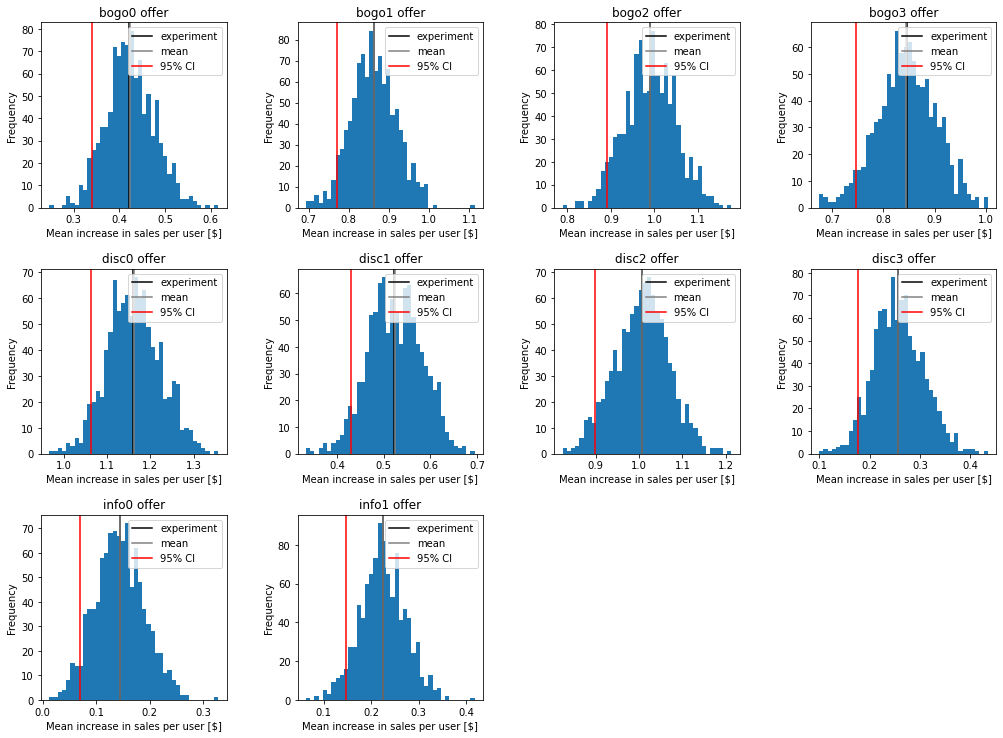

In [38]:
plot_confidence_spending_change_by_offer(user_event_data, 6)

every offer has a positive impact on the mean user revenue
General observations are
- the discount offer 0 & 2 increases revenue the most
- BOGO offers & discount offers are doing better than purely informational offers
- the impact of the offers in different waves is quite similar

However this is only looking at the increase in spending. The reward is not considered since there is no information  actually much a reward actually costs the company. For a BOGO offer with a reward of 5$ one would have to consider not 5$ but a lot less since the production cost is far less than the sale price. For a discount offer this is the same problem. Only for the informational offers we really can judge the impact on revenue. Which is positive :)

Going into more detail comparing different offers per type:

BOGO offers
- offer 0 & 1 do have the same difficulty and reward. However offer 1 is doing a lot better. The difference is that offer 0 is also distributed via social media. This seems to be an important factor
- Offer 2 & 3 also do have the same reward. Offer 2 is doing slightly better. The difference is that offer 2 is running two days longer and does not get distributed via web. This is a hint that an increase in offer time is beneficial. Two additioal days are more rewarding than the downside of not distributing via web.

Discount offers
- offer 0 and offer 1 do have the same reward and difficulty. Offer 1 does not get distributed via social media and has a decreased duration of 3 days. Offer 0 is doing far better than offer 1. This indicates that here as well social media is crucial for the success of an offer
- offer 0 and bogo offer 3 only differ in the kind of reward. The reward of the bogo offer is 5 times the amount of the discount. However the discount is doing a lot better. This indicates that people like discounts.
- offer 2 is a improved version of offer 0. The reward is increased by 1$ and the diffuculty decreased by 3$. The only downside is that the duration is decreased by 3 days. Surprisingly offer 2 is doing worse. So an increased reward and a decrease in difficutly surprisingly have less beneficial impact than an increase in duration
- offer 3 is doing worse. It has by far the highest difficulty of 20$ but at the same time also a higher reward of 5. It is only distributed by web and email. This confirums that not sending out the offer via mobile and social media really hurts

Informational offers
- offer 0 has a day longer duration and does not get distributed via social media. Offer 1 does not get distributed by web. Offer 1 is doing a lot better. This again is a hint for the high importance of distribution via social media.

We could gain more insights by comparing offers from different groups with eachother or the groups that actually viewed the offer. This unfortunatly is not in the time frame of this project.

What we learn:
- all offers increase revenue.
- we do not have the business understanding to decide what offer increases profit.
- distribution over the right channels is crucial for the success of your offer campaign. Do not forget social media and mobile.
- people like discounts more than BOGO. Even if the reward is not that high.

## Offer view rate and completion
Another measure to conclude how sucessful an offer is is the view and completion count of the different offers. Let´s have a look at them:

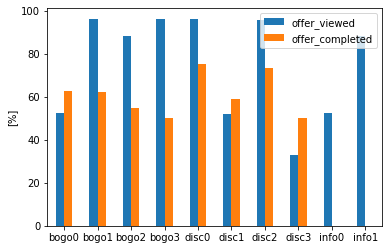

In [39]:
offer_data = transcript.groupby('offer_short_name').sum()
offer_data/offer_data.offer_received

(offer_data.div(offer_data.offer_received,axis = 0)*100)[['offer_viewed', 'offer_completed']].plot.bar(rot = 0);
plt.xlabel("");
plt.ylabel("[%]");

General observations 
- the amount of views is closely related to the way of distribution. There seems to be not a lot of relation to the actual offer itself. Offers being sent via all channels have a close to 100% view rate.
- missing out to sent the offer by web like for bogo2 and info1 only decreases the vew rate by around 5%.
- not sending out offers via social media hurt a lot. bogo0, disc1 and info0 have a lower than 55% view rate.
- bogo0, disc1 and disc 3 have a higher completion rate than vew rate. The amount of offers being completed but never viewed have to be quite high. By preventing this one could generate substantial business value since rewards are given out for no clear benefit. 

# What to do to increase business value?
We want to implement a recommendation engine that increases business value. Now there is the question what we are exactly going to do?

The best recommendation model would give out recommendations that directly increase/maximize company profit. For this we would have to send out the optimal offers regarding increase of profit per user. Unfortunatly we realized that we do not have enough business understanding and would have to work with a lot of assumptions. So the fallback option would be to recommend to maximize revenue. 
Creating labels for each person is difficult since we do have very little historic data. To see if we increase spending we would need more historic data for each user. Currently we could compare the period where an user is not under the influence of an offer to the one where the user get´s a specific offer. Since most of the users get four or more offers during the 6 offer waves that is expected to be very sparse data.

We also learned that the method of distribution and therefore getting the offer to the user is crucial for the sucess of an offer campaign as well. Creating a recommendation engine that recommends offers that are completed most likely is something that is a lot more feasible with the given data. Since we showed that all offers increase revenue this should have a positive impact on company profit.
Using this recommendation we also can generate business value by predicting the case where someone completes the offer without ever viewing it. As analyzed there is a significant cases where this is actually happening. This way we can prevent giving out rewards without receiving a benefit since the transaction most likely would have happened anyways. The scope of this project is limited we will now focuse on this

## Recommendation engine
We decided on creating a recommendation engine that recommends offers to users with the goal to maximize the offer completion. And at the same time minimze the completion of offers that werent viewed.
For the recommendation we can follow a classification approach only using the user attributes. Another way is using FunkSVD as a collaborative method that makes use of information provided by similar users. We will implement both. Compare their performance and try to combine them at the end.

### Label engineering
All cases we want to predict:
- viewed -> not completed
- viewed -> completed
- not viewed -> not completed
- not viewed -> completed
Informational offers do not have a completed event. It can be argued that viewing them is their completion. We won´t do that and see no informational offer as completable.

There are now multiple possible ways of creating the labels. The simplest option is to treat all offers independent of time and treat each offer sent to a customer as a separate case disregarding all historic data. Another option would be to consider all events happening until the offer reaches the customer. This would enable us to engineer more features like "average spending", "previous offer fail rate", etc which should improve classifier results. Due to the limited scope of the project we will only explore treating all offers independet of the event history.


In [40]:
def generate_labels(transcript,portfolio,profile):
    """Generates labels for following user - offer combinations:
    - viewed -> not completed
    - viewed -> completed
    - not viewed -> not completed
    - not viewed -> completed
    
    Informational offers do not have a completed event. It can be argued that viewing 
    them is their completion. We won´t do that and see no informational offer as completable.

    Args:
        transcript (df): df containing event data

    Returns:
        df: df containing labels and matching user - offer combination
    """
    
    # let´s create the labels. therefore we need to compare the time of the events
    label_data = transcript.groupby(['person', 'offer_short_name','time'])[['offer_completed','offer_received','offer_viewed']].sum().copy()
    # increase time by one so we can distinguish between viewing at time 0 and not viewing
    label_data.index.set_levels(label_data.index.levels[2]+1,level=2, inplace=True)
    label_data = label_data.where(label_data <= 0, np.array([label_data.index.get_level_values('time'),]*3).transpose()).groupby(['person', 'offer_short_name']).sum()
    # now make every offer - person combination a row
    label_data['person'] = label_data.index.get_level_values(0)
    label_data = label_data.droplevel(0)
    label_data.reset_index(inplace=True)
    label_data['viewed_not_completed'] = (label_data.offer_viewed > 0) & (label_data.offer_completed < label_data.offer_viewed)
    label_data['viewed_completed'] = (label_data.offer_viewed > 0) & (label_data.offer_completed >= label_data.offer_viewed)
    label_data['not_viewed_not_completed'] = (label_data.offer_viewed <= 0) & (label_data.offer_completed <= label_data.offer_viewed)
    label_data['not_viewed_completed'] = (label_data.offer_viewed <= 0) & (label_data.offer_completed > label_data.offer_viewed)
    label_data.drop(columns=['offer_completed', 'offer_received', 'offer_viewed'],inplace = True)
        
    label_data = label_data.merge(portfolio.drop(columns=['offer_id']), on='offer_short_name', how='left')
    label_data = label_data.merge(profile.rename(columns={'id' : 'person'}), on='person', how='left')
    label_data['offer'] = pd.Categorical(label_data['offer_short_name'],categories= label_data['offer_short_name'].unique()).codes
    label_data['user_id'] = pd.Categorical(label_data['person'],categories= label_data['person'].unique()).codes
    label_data.drop(columns=['person','offer_short_name'], inplace = True)
    
    label_data = label_data.join(pd.get_dummies(label_data.gender, dtype=np.int16))
    label_data.drop(columns=['gender'],inplace = True)
    label_data['days_signedup'] = (-(label_data.became_member_on - label_data.became_member_on.max())).dt.days
    label_data.drop(columns=['became_member_on'],inplace = True)
    
    label_names = ['viewed_not_completed','viewed_completed','not_viewed_not_completed','not_viewed_completed']
    X = label_data.drop(columns=label_names).copy()
    y = label_data[label_names].copy()
    return X, y, y.columns
    

### Exploratory training - non collaborative method

Let´s get a feeling for the difficulty of the different task. Therefore we train a classifier that only get´s the individual user-offer pairs as an input. Later we will also have a look at an colaboeative aproach.

#### Predict all outcomes

In [191]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, \
recall_score, f1_score

def exploratory_RF_training(X_train, X_test, y_train, y_test,class_weight = None):
    """Trains a random forest classifier and generates a report it´s performance on the test data.

    Args:
        X_train : training data
        X_test : test data
        y_train : training labels
        y_test : test labels
        class_weight : weight of classes considered by RF clf
    """
    
    clf = RandomForestClassifier(class_weight=class_weight, n_jobs=-1, random_state=42)
    clf.fit(X_train, y_train)
    y_pred_test = clf.predict(X_test)
    print("Accuracy Score:" + str(accuracy_score(y_test, y_pred_test)))
    target_names = y.columns.to_list()
    # binary classificaiton needs a second label
    if len(target_names) == 1:
        target_names.append("not " + target_names[0])
    print(classification_report(y_test, y_pred_test,target_names = target_names))
    try:
        plot_confusion_matrix(clf, X_test, y_test);
    except:
        pass

X, y,_ = generate_labels(transcript,portfolio,profile)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
exploratory_RF_training(X_train, X_test, y_train, y_test)

C:\Users\patri\AppData\Local\Temp/ipykernel_26368/685542018.py:21: FutureWarning: inplace is deprecated and will be removed in a future version.
  label_data.index.set_levels(label_data.index.levels[2]+1,level=2, inplace=True)


Accuracy Score:0.49950203712086916
                          precision    recall  f1-score   support

    viewed_not_completed       0.69      0.61      0.65      4627
        viewed_completed       0.64      0.52      0.57      3848
not_viewed_not_completed       0.58      0.34      0.43      1665
    not_viewed_completed       0.47      0.11      0.18       905

               micro avg       0.65      0.50      0.57     11045
               macro avg       0.59      0.40      0.46     11045
            weighted avg       0.64      0.50      0.55     11045
             samples avg       0.50      0.50      0.50     11045



C:\Users\patri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Predicting all outcomes at once yields suboptimal results. The low accuracy and F1 scores indicate that the classifier is not able to separate all the different classes in a meaningful way. Especially the class not_viewed_completed seems to be difficult.

#### Predicting offer completion

C:\Users\patri\AppData\Local\Temp/ipykernel_26368/685542018.py:21: FutureWarning: inplace is deprecated and will be removed in a future version.
  label_data.index.set_levels(label_data.index.levels[2]+1,level=2, inplace=True)
C:\Users\patri\AppData\Local\Temp/ipykernel_26368/1252236355.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


Accuracy Score:0.7426889995473065
               precision    recall  f1-score   support

    completed       0.78      0.84      0.81      7245
not completed       0.64      0.56      0.60      3800

     accuracy                           0.74     11045
    macro avg       0.71      0.70      0.71     11045
 weighted avg       0.74      0.74      0.74     11045



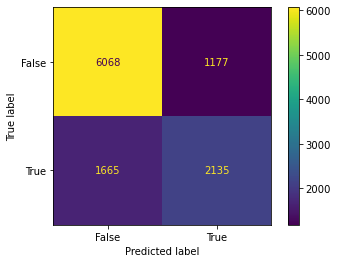

In [188]:
X, y, category_names = generate_labels(transcript,portfolio,profile)
y['completed'] = y.viewed_completed
y = y.filter(['completed'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
exploratory_RF_training(X_train, X_test, y_train, y_test)

As expected it is more easy to separate completion. The performance seems okay given no feature engineering that takes historic user event data into account and no collaborative information was done so far. 

### Predicting completion without viewing the offer
Now we can have a look if we are able to predict offers that we do not want to sent out. There we have to consider that the classes are imbalanced. There are a lot less completed_but_no_view cases than other. To deal with the class imbalanced we use the balanced option of the classifier that  automatically adjust weights inversely proportional to class frequencies.

C:\Users\patri\AppData\Local\Temp/ipykernel_26368/685542018.py:21: FutureWarning: inplace is deprecated and will be removed in a future version.
  label_data.index.set_levels(label_data.index.levels[2]+1,level=2, inplace=True)
C:\Users\patri\AppData\Local\Temp/ipykernel_26368/1573012294.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


Accuracy Score:0.9107288365776369
                          precision    recall  f1-score   support

    not_viewed_completed       0.92      0.99      0.95     10103
not not_viewed_completed       0.39      0.08      0.14       942

                accuracy                           0.91     11045
               macro avg       0.65      0.53      0.54     11045
            weighted avg       0.87      0.91      0.88     11045



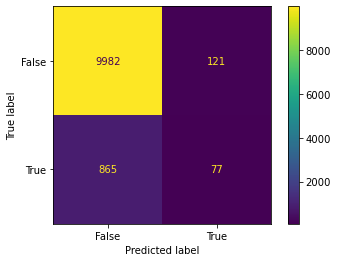

In [193]:
X, y, category_names = generate_labels(transcript,portfolio,profile)
y = y.filter(['not_viewed_completed'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

category_names = ['completed_but_no_view', 'other']
exploratory_RF_training(X_train, X_test, y_train, y_test, class_weight = 'balanced')

Out classifier is not able to separate the different classes. Even though we do have a very high accuracy the F1 score is sad. We do have a lot more FNs and FPs than correct predicitons. The classifier is not beneficial in this use case.

### Conclusion
Since we do have limited time in this project we will focuse on the most promising case and investigate this one further. This is the binary prediction task if a offer gets completed or not. 

## Offer completion - further investigation
- We will optimize the traditional classificaiton aproach
- investigate the performance of a collaborative aproach
- try to combine them

### Classifier optimization

Let´s try to improve our performance doing parameter tuning by cross validated grid search:


C:\Users\patri\AppData\Local\Temp/ipykernel_26368/685542018.py:21: FutureWarning: inplace is deprecated and will be removed in a future version.
  label_data.index.set_levels(label_data.index.levels[2]+1,level=2, inplace=True)


Accuracy Score:0.7304737516005122
              precision    recall  f1-score   support

       False       0.76      0.86      0.81     35943
        True       0.64      0.49      0.55     18727

    accuracy                           0.73     54670
   macro avg       0.70      0.67      0.68     54670
weighted avg       0.72      0.73      0.72     54670



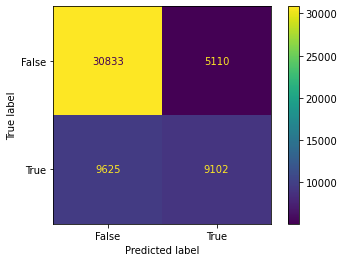

In [200]:

X, y, category_names = generate_labels(transcript,portfolio,profile)
y['completed'] = y.viewed_completed
y = y.filter(['completed'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier( random_state=42)
parameters = {
    'bootstrap': [True, False],
    'n_estimators': [1400, 1000, 800],
    'max_depth' : [3,5,8]
}
model = GridSearchCV(clf, param_grid=parameters, scoring="accuracy", verbose=0)
model.fit(X_train, y_train.to_numpy().ravel())
y_pred_test = model.predict(X_test)
print("Accuracy Score:" + str(accuracy_score(y_test, y_pred_test)))
print(classification_report(y_test, y_pred_test))
plot_confusion_matrix(model, X_test, y_test);

We slightly improve the performance by finding more suitable hyper parameters.

To improve performance further we need to understand our model better. For now we will only analyze the importance of our features. We can do that analyzing the impact of permutating values of individual features:

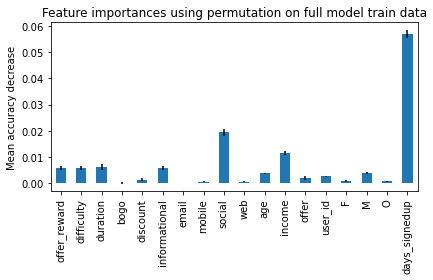

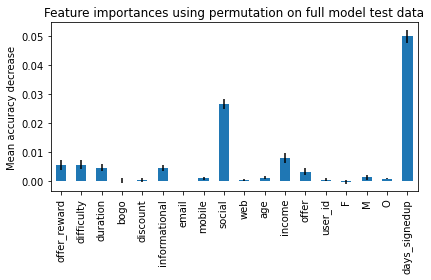

In [227]:
from sklearn.inspection import permutation_importance

def plot_permutation_importance(model, X, y, plot_str = ""):
    """plots the permutation importance of features the model was trained with

    Args:
        model : trained classifier
        X : features
        y : labels
    """
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=2)
    feature_importances = pd.Series(result.importances_mean, index=X.columns)
    fig, ax = plt.subplots()
    feature_importances.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title("Feature importances using permutation on full model "+plot_str)
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show()
    
plot_permutation_importance(model, X_train, y_train,"train data")
plot_permutation_importance(model, X_test, y_test,"test data")

The importances are roughly the same for test and trainig data. We can see that the most important feature according to this method is the days a user is signed up. When two features are correlated and one of the features is permuted, the model will still have access to the feature through its correlated feature. This will result in a lower importance value for both features, where they might actually be important.
What we learn from this evaluation though are the important features that do not have no other correlated features. Which in this case are the days signed up. 
Another thing we learn are features that we are overfitting in training and have a negative impact on test accuracy.
We learn that there is a negative impact of the features indicating if the offer is bogo or discount. The only relevant feature is if it´s an informational offer or not. The same applies for the distribution channel email. The model does not get a benefit from knowing if the offer was sent by mail or not. So let´s remove the features with low importance and see how our model performs:

C:\Users\patri\AppData\Local\Temp/ipykernel_26368/685542018.py:21: FutureWarning: inplace is deprecated and will be removed in a future version.
  label_data.index.set_levels(label_data.index.levels[2]+1,level=2, inplace=True)


Accuracy Score:0.7583521955636034


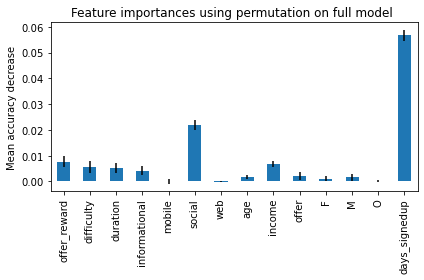

In [392]:
X, y, category_names = generate_labels(transcript,portfolio,profile)
y['completed'] = y.viewed_completed
y = y.filter(['completed'])
X.drop(columns = ['discount', 'bogo','user_id','email'], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
random_forest_best_params = RandomForestClassifier(max_depth=8, n_estimators=800, random_state=42)
model = random_forest_best_params
model.fit(X_train, y_train.to_numpy().ravel())
y_pred_test = model.predict(X_test)
print("Accuracy Score:" + str(accuracy_score(y_test, y_pred_test)))

plot_permutation_importance(model, X_test, y_test)

We slightly improved the model performance. Let´s see if we can remove more

C:\Users\patri\AppData\Local\Temp/ipykernel_26368/685542018.py:21: FutureWarning: inplace is deprecated and will be removed in a future version.
  label_data.index.set_levels(label_data.index.levels[2]+1,level=2, inplace=True)


Accuracy Score:0.7598008148483477


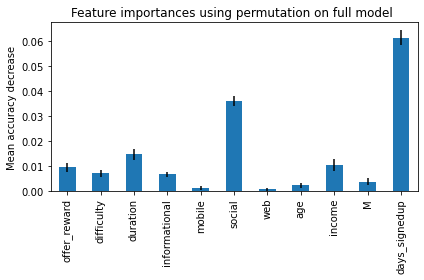

In [395]:
X, y, category_names = generate_labels(transcript,portfolio,profile)
y['completed'] = y.viewed_completed
y = y.filter(['completed'])
X.drop(columns = ['discount', 'bogo','user_id','email','offer','F','O'], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
random_forest_best_params = RandomForestClassifier(max_depth=8, n_estimators=800, random_state=42)
model = random_forest_best_params
model.fit(X_train, y_train.to_numpy().ravel())
y_pred_test = model.predict(X_test)
print("Accuracy Score:" + str(accuracy_score(y_test, y_pred_test)))

plot_permutation_importance(model, X_test, y_test)

We managed to reduce the features even more. Removing more features does not lead to an increase in accuracy.
We now know that for the users
- the days signed up is the most relevant criteria
- the second most relevant criteria is income
- males differ significant in behavior from female and other
- the age of a user has limited impact

We know that for offers
- the most significant feature is if it get´s distributed by social media or not
- the size of the reward, duration and difficulty are important

To improve the performance further we could invest more into feature engineering. One option would be to add more metrics to the user like number of transactions per week, dollars per transaction, etc. Due to the limited scope of this project this is not further explored. Instead we will compare the result to the performance of a colaborative aproach and try to combine them.

### Collaborative prediction
In order to make use of the information of other users we use an collaborative approach using FunkSvd. The estimator is implemented as an SKlearn estimator in order to make use of it´s framework functions.

In [355]:

def funkSVD(user_offer_matrix, latent_features=12, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    user_offer_matrix - (numpy array) a matrix with users as rows, offers as columns, and completion as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) a latent feature by offer matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = user_offer_matrix.shape[0]
    n_ratings = user_offer_matrix.shape[1]
    
    # initialize the user and offer matrices with random values
    np.random.seed(42)
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_ratings)
    
    ratings_matrix = user_offer_matrix.to_numpy()
    # for each iteration
    for iteration in range(iters):

        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_ratings):
                
                # if the rating exists
                if ~np.isnan(ratings_matrix[i, j]):
                    
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = ratings_matrix[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

    return pd.DataFrame(user_mat,index=user_offer_matrix.index.get_level_values(0)),\
        pd.DataFrame(offer_mat,columns=user_offer_matrix.columns.get_level_values(1)) 

def funkSVD_predict_completion(user_matrix, offer_matrix, user_id, offer_id):
    '''
    Predicts if an offer will get completed by an user or not
    INPUT:
    user_matrix - user by latent factor matrix
    offer_matrix - latent factor by offer matrix
    user_id - the user_id from the reviews df
    offer_id - the offer_id according the offer df
    
    OUTPUT:
    pred - the predicted competion probability for user_id-offer_id according to FunkSVD
    '''
    # Use the training data to create a series of users and offer that matches the ordering in training data
    # User row and offer Column
    
    user_factors = user_matrix.loc[user_id]
    offer_factors = offer_matrix[offer_id]
    # Take dot product of that row and column in U and V to make prediction
    pred = np.dot(user_factors,offer_factors)
    return pred

def funkSVD_predict_batch(user_offer_data, user_offer_pred, threshold_values=True):
    """Predicts if an offer will get completed by an user or not for all user offer combinations

    Args:
        user_offer_data : data about users and offers
        user_offer_pred : prediction got by matrix decomposition
        threshold_values (bool, optional): If Fals returns probability. If tresholds probability to
        zero or one. Defaults to True.

    Returns:
        pd.DataFrame: data frame containing predictions for completion of user offer pairs
    """
    user_offer_pairs = user_offer_data[['user_id','offer']].copy()
    predictions = []
    
    for i, row in user_offer_pairs.iterrows():
        try:
            predictions.append(user_offer_pred.loc[row[0]][row[1]])
        except:
            predictions.append(0.49999)
    pred = pd.DataFrame(predictions,columns=["completed"])
    # in order to make a classify we have to treshold the values and decide what to do with non predictions
    # for now we do not consider the non predicitons and make them zero
    if threshold_values:
        pred = pred.where(pred > 0.5,False).where(pred < 0.5,True).astype(bool)
    return pred

def make_user_offer_matrix_from_labels(user_offer_data,completed,additional_features = False):
    """Performs the FunkSVD matrix decomposition and returns the user and offer matrices.
       Using these we can make a prediciton for of all users offer pairs. 

    Args:
        user_offer_data : data about users and offers
        completed : information if a user offer combination was completed or not
        additional_features (bool, optional): Additional features from the user can be taken into account.
        Defaults to False.

    Returns:
        user_offer_matrix containing users as columns, offers as rows and 1/0 for completed or not
    """
    # using sklearn methods the label might get converted to an array
    if ~isinstance(completed, pd.DataFrame):
        completed = pd.DataFrame(completed,columns=['completed'])
    svd_train_data = user_offer_data.join(completed)[['user_id','offer', 'completed']]
    user_offer_matrix = svd_train_data.groupby(['user_id','offer']).any()\
        .unstack().replace(True, 1).replace(False, 0)
    user_features = user_offer_data.groupby('user_id').median()
    if additional_features:
        user_offer_matrix['completed',10] = user_features.days_signedup/user_features.days_signedup.max()*2
        #user_offer_matrix['viewed_completed',14] = user_features.days_signedup/user_features.days_signedup.max()
    return user_offer_matrix

In [364]:
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class FunkSvdEstimator(BaseEstimator):
    """Implements the FunkSvd algorithm as an SKlearn estimator
    """

    def __init__(self, latent_features=6, learning_rate=0.015, iters=80, additional_features=False):
        """Initializes the parameters of the model

        Args:
            latent_features (int, optional): No of latent features. Defaults to 6.
            learning_rate (float, optional): SVD learning rate. Defaults to 0.015.
            iters (int, optional): . Iterations of matrix decomposition to 80.
            additional_features (bool, optional): Adds user information as features. Defaults to False.
        """
        self.latent_features = latent_features
        self.iters = iters
        self.learning_rate = learning_rate
        self.additional_features = additional_features
        self._estimator_type = "classifier"

    def fit(self, X_train, y_train):
        """Fits the model
        """
        self.x_column_names = X_train.columns
        user_offer_matrix = make_user_offer_matrix_from_labels(X_train, y_train)
        self.user_mat, self.offer_mat = funkSVD(user_offer_matrix, latent_features=self.latent_features,\
            learning_rate=self.learning_rate, iters=self.iters)
        self.user_offer_pred = np.matmul(self.user_mat,self.offer_mat)
        return self

    def predict(self, X):
        """Predicts based on user offer pairs

        Args:
            X : user_offer pairs

        Returns:
            prediciton if user will complete offer
        """
        # Check is fit had been called
        check_is_fitted(self)
        if ~isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X,columns=self.x_column_names)
        y_pred = funkSVD_predict_batch(X, self.user_offer_pred)
        return y_pred
    
    
    def predict_proba(self, X):        
        """Predicts based on user offer pairs

        Args:
            X : user_offer pairs

        Returns:
            Probability if user will complete offer. This is not strictly mathematical to take the
            SVD value but a good enough approximation.
        """
        # Check is fit had been called
        check_is_fitted(self)
        if ~isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X,columns=self.x_column_names)
        y_pred = funkSVD_predict_batch(X, self.user_offer_pred,threshold_values=False)
        return np.array([y_pred+0,-(y_pred-1)]).transpose()[0]

Let´s have a look at the initial performance:

C:\Users\patri\AppData\Local\Temp/ipykernel_26368/685542018.py:21: FutureWarning: inplace is deprecated and will be removed in a future version.
  label_data.index.set_levels(label_data.index.levels[2]+1,level=2, inplace=True)
C:\Users\patri\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\patri\AppData\Local\Temp/ipykernel_26368/113030485.py:35: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the

Accuracy Score:0.6646446355817112
              precision    recall  f1-score   support

       False       0.75      0.72      0.74      7166
        True       0.52      0.56      0.54      3879

    accuracy                           0.66     11045
   macro avg       0.64      0.64      0.64     11045
weighted avg       0.67      0.66      0.67     11045

Accuracy Score:0.9992303687439165
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     29152
        True       1.00      1.00      1.00     15025

    accuracy                           1.00     44177
   macro avg       1.00      1.00      1.00     44177
weighted avg       1.00      1.00      1.00     44177



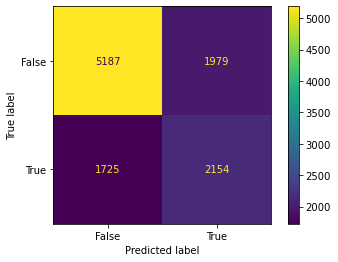

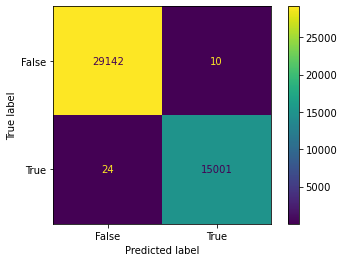

In [372]:
X, y, category_names = generate_labels(transcript,portfolio,profile)
y['completed'] = y.viewed_completed
y = y.filter(['completed'])
X.reset_index(drop=True,inplace=True)
y.reset_index(drop=True,inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = FunkSvdEstimator(latent_features=5,\
    learning_rate=0.005, iters=400)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
print("Accuracy Score:" + str(accuracy_score(y_test, y_pred_test)))
print(classification_report(y_test, y_pred_test))
plot_confusion_matrix(model, X_test, y_test);
y_pred_train = model.predict(X_train)
print("Accuracy Score:" + str(accuracy_score(y_train, y_pred_train)))
print(classification_report(y_train, y_pred_train))
plot_confusion_matrix(model, X_train, y_train);

We can see that the algorithm implementation is working since we are overfitting on the training set. The FunkSVD algorithm initialy performs worse than the previously trained RandomForest classifier. Let´s see if we can improve that finding better hyperparameters.

In [377]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

clf = FunkSvdEstimator()
parameters = {
    'latent_features': [3,4,5,8, 10],
    'iters': [80, 150,200,300],
    'additional_features' : [True,False]
}
model = GridSearchCV(clf, param_grid=parameters, scoring="accuracy" ,cv=3, verbose=100, n_jobs=8)
model.fit(X_train, y_train)
model.best_estimator_,model.best_score_

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed: 1024.3min
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed: 1024.3min
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed: 1024.4min
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed: 1024.7min
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed: 1024.7min
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed: 1024.7min
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed: 1025.0min
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed: 1025.0min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed: 1028.1min
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed: 1028.7min
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed: 1028.8min
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed: 1029.0min
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed: 1029.4min
[Parallel(n_jobs=8)]: Done  14 tasks      | 

C:\Users\patri\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\patri\AppData\Local\Temp/ipykernel_26368/113030485.py:35: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  self.user_offer_pred = np.matmul(self.user_mat,self.offer_mat)


(FunkSvdEstimator(additional_features=True, latent_features=3),
 0.6734499321736015)

In [387]:
pd.DataFrame(model.cv_results_)[['rank_test_score','mean_test_score','param_iters','param_latent_features']].sort_values(by="rank_test_score").head(15)

,rank_test_score,mean_test_score,param_iters,param_latent_features
0,1,0.673450,80,3
20,1,0.673450,80,3
25,3,0.669579,150,3
5,3,0.669579,150,3
30,5,0.666976,200,3
10,5,0.666976,200,3
1,7,0.664509,80,4
21,7,0.664509,80,4
35,9,0.664147,300,3
15,9,0.664147,300,3


Accuracy Score:0.69506564056134
              precision    recall  f1-score   support

       False       0.75      0.78      0.76      6880
        True       0.60      0.56      0.58      4165

    accuracy                           0.70     11045
   macro avg       0.67      0.67      0.67     11045
weighted avg       0.69      0.70      0.69     11045



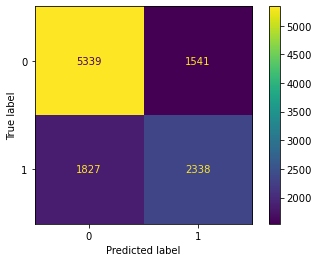

In [388]:
y_test_pred = model.predict(X_test)
print("Accuracy Score:" + str(accuracy_score(y_test, y_test_pred)))
print(classification_report(y_test_pred, y_test))
cm = confusion_matrix(y_test_pred, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()

We do gain a bit of performance reducing the number of latent features and training iterations. However we are still performing worse than the random forest classifier. Let´s see if there is a benefit in combining both of them.

## Combining RandomForest and FunkSVD
We now saw that the random forest outperforms the FunkSvd algorithm on the dataset. Now there is the chance that both algorithms complement eachother. FunkSVD ahould benefit in all cases where no prediction can be made. The random forest classifier could benefit from the collaborative knowledge of the FunkSvd classifier.
One option to combine both models is stacking of both classifiers:

In [390]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

X, y, category_names = generate_labels(transcript,portfolio,profile)
y = y.viewed_completed

X.drop(columns = ['discount', 'bogo','email','mobile','F','O'], inplace=True)
X.reset_index(drop=True,inplace=True)
y.reset_index(drop=True,inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 42)

base_clfs = [
                 ('rf_1', FunkSvdEstimator(additional_features=False, iters=80, latent_features=3, learning_rate=0.005)),
                 ('rf_2', RandomForestClassifier(bootstrap=False, max_depth=8, n_estimators=800))             
            ]

# Initialize Stacking Classifier with the Meta Learner
clf = StackingClassifier(estimators=base_clfs, final_estimator=LogisticRegression(),\
       stack_method= 'predict_proba',verbose = True)
clf.fit(X_train, y_train)

C:\Users\patri\AppData\Local\Temp/ipykernel_26368/685542018.py:21: FutureWarning: inplace is deprecated and will be removed in a future version.
  label_data.index.set_levels(label_data.index.levels[2]+1,level=2, inplace=True)
C:\Users\patri\AppData\Local\Temp/ipykernel_26368/113030485.py:35: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  self.user_offer_pred = np.matmul(self.user_mat,self.offer_mat)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\patri\AppData\Local\Temp/ipykerne

StackingClassifier(estimators=[('rf_1',
                                FunkSvdEstimator(latent_features=3,
                                                 learning_rate=0.005)),
                               ('rf_2',
                                RandomForestClassifier(bootstrap=False,
                                                       max_depth=8,
                                                       n_estimators=800))],
                   final_estimator=LogisticRegression(),
                   stack_method='predict_proba', verbose=True)

Accuracy Score:0.7553644182888185
              precision    recall  f1-score   support

       False       0.88      0.77      0.82      8222
        True       0.52      0.70      0.59      2823

    accuracy                           0.76     11045
   macro avg       0.70      0.74      0.71     11045
weighted avg       0.79      0.76      0.77     11045



array([[0.0075795 , 6.18560192]])

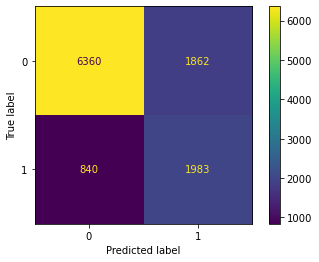

In [391]:
y_test_pred = clf.predict(X_test)
print("Accuracy Score:" + str(accuracy_score(y_test, y_test_pred)))
print(classification_report(y_test_pred, y_test))
cm = confusion_matrix(y_test_pred, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()
clf.final_estimator_.coef_

In [ ]:
model.best_estimator_,model.best_score_
model.cv_results_

{'mean_fit_time': array([ 9.8731205 , 14.24338551, 12.3766098 ,  5.9600893 ,  9.5177886 ,
        11.37084289]),
 'std_fit_time': array([0.29920367, 0.4447718 , 2.69683683, 0.07798008, 0.5318071 ,
        0.29054232]),
 'mean_score_time': array([1.10843391, 1.11381693, 0.66605549, 0.6654788 , 0.75111613,
        0.67177095]),
 'std_score_time': array([0.06772524, 0.09979362, 0.0201975 , 0.01990509, 0.05071976,
        0.01083292]),
 'param_additional_features': masked_array(data=[True, True, True, False, False, False],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_iters': masked_array(data=[10, 10, 10, 10, 10, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_latent_features': masked_array(data=[5, 10, 15, 5, 10, 15],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 '

Accuracy Score:0.6900860117700317
              precision    recall  f1-score   support

       False       0.82      0.74      0.77      7975
        True       0.45      0.57      0.50      3070

    accuracy                           0.69     11045
   macro avg       0.64      0.65      0.64     11045
weighted avg       0.72      0.69      0.70     11045



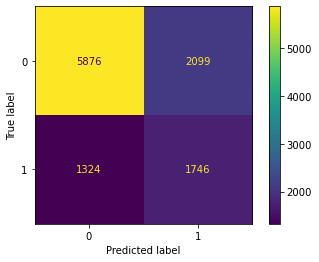

In [ ]:
y_test_svd_pred = model.predict(X_test)
print("Accuracy Score:" + str(accuracy_score(y_test, y_test_svd_pred)))
print(classification_report(y_test_svd_pred, y_test))
cm = confusion_matrix(y_test_svd_pred, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [ ]:
user_offer_matrix_ext = make_user_offer_matrix_from_labels(X_train, y_train)
user_mat_ext, offer_mat_ext = funkSVD(user_offer_matrix_ext, latent_features=14, learning_rate=0.015, iters=150)

As a sanity check test performace of the training set. We are completely fitting the training set which is expected doing any kind of SVD. Let´s have a look at our test performance:

The collaborative aproach has lower performance then the classifier. It seems that the class separability in general is worse and on a quite low level. Still we are a bit better than rolling a dice.

              precision    recall  f1-score   support

       False       0.68      0.65      0.67      7524
        True       0.32      0.35      0.34      3521

    accuracy                           0.56     11045
   macro avg       0.50      0.50      0.50     11045
weighted avg       0.57      0.56      0.56     11045

              precision    recall  f1-score   support

       False       0.68      0.66      0.67     30134
        True       0.32      0.34      0.33     14043

    accuracy                           0.56     44177
   macro avg       0.50      0.50      0.50     44177
weighted avg       0.57      0.56      0.56     44177



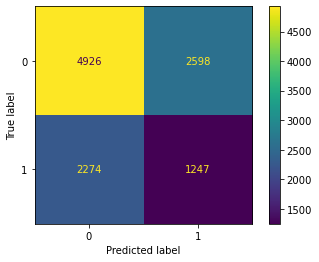

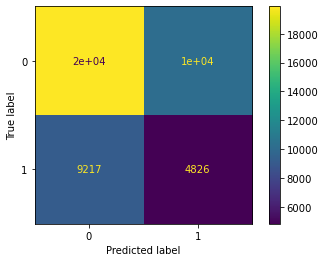

In [ ]:
print(classification_report(y_test_svd_pred, y_test))
cm = confusion_matrix(y_test_svd_pred, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()
print(classification_report(y_train_svd_pred, y_train))
cm = confusion_matrix(y_train_svd_pred, y_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()

Accuracy Score:0.7221367134449977
               precision    recall  f1-score   support

    completed       0.86      0.68      0.76      7200
not completed       0.57      0.80      0.67      3845

     accuracy                           0.72     11045
    macro avg       0.72      0.74      0.71     11045
 weighted avg       0.76      0.72      0.73     11045



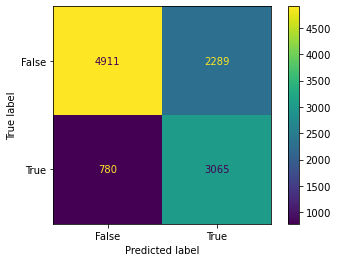

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
X_test_svd = X_test.join(funkSVD_predict_batch(X_test, user_mat, offer_mat,threshold_values=False))
X_train_svd = X_train.join(funkSVD_predict_batch(X_train, user_mat, offer_mat,threshold_values=False))

#print(classification_report(X_test_svd, y_test))
#cm = confusion_matrix(X_test_svd, y_test)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()

category_names = ['completed', 'not completed']
exploratory_training(X_train_svd, X_test_svd, y_train, y_test, category_names)

              precision    recall  f1-score   support

       False       0.69      0.65      0.67      7641
        True       0.31      0.34      0.32      3404

    accuracy                           0.56     11045
   macro avg       0.50      0.50      0.50     11045
weighted avg       0.57      0.56      0.56     11045



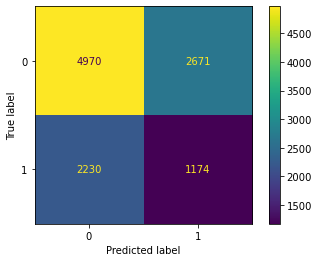

In [ ]:

print(classification_report(X_test_svd.viewed_completed, y_test))
cm = confusion_matrix(X_test_svd.viewed_completed, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot()

## Takeaways

- a big challenge was to understand the experiment itself. Most of the informations about the experiment had to be reverse engineered from the data. Only with understanding the experiment it was possible to figure out what business value we can generate from the data.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, \
recall_score, f1_score

def exploratory_RF_training(X_train, X_test, y_train, y_test):
    
    clf = RandomForestClassifier(max_depth=8, n_estimators=800, n_jobs=-1,
                        random_state=42)
    parameters = {
        'bootstrap': [True, False],
        'n_estimators': [1400, 1000],
        'max_depth' : [30,15,8]
    }
    model = GridSearchCV(clf, param_grid=parameters, scoring="accuracy" , cv = 2, verbose=3)
    model = clf
    model.fit(X_train, y_train)
    #print(model.best_estimator_)
    #print(model.best_score_)
    #print(model.cv_results_)
    y_pred_test = model.predict(X_test)
    print("Accuracy Score:" + str(accuracy_score(y_test, y_pred_test)))
    print(classification_report(y_test, y_pred_test,target_names = y.columns))
    try:
        plot_confusion_matrix(model, X_test, y_test);
    except:
        pass

X, y, category_names = generate_labels(transcript,portfolio,profile)
category_names = y.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
exploratory_RF_training(X_train, X_test, y_train, y_test)